In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from __future__ import print_function, division
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import pandas as pd
import seaborn.apionly as sns
import matplotlib.ticker as ticker
import math
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import random as rand
# from sys import maxint
import scipy.stats as ss
import itertools
from itertools import islice, takewhile
import operator
from scipy.stats import t, cauchy, norm
from functools import reduce
import scipy

/home/mkhoshle/miniconda3/envs/research/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


## Simulations

In [2]:
def sim(n_initial,n,rates):
    nn_A = 1;nn_photon = 0;nn_D= 0
    chk = True;j = 0;state = 0

    # Time necessary for activating the fluorephore
    t_activation = -math.log(np.random.uniform())*(1./rates['ka'])          #[s]
    t = t_activation                                                        #[s]
    t_photon_back = -math.log(np.random.uniform())*(1./rates['miu_back'])   #[s]
    t0 = t + t_photon_back                                                  #[s]
    nn_A = nn_A+1
    
    n['state'].append(1)
    n['time'].append(t)
    n['n_photon'].append(1) 
    n_initial['n_A'] = 1.0
    j = j+1
    
    C_miu = [rates['miu'],rates['kd'],rates['kr'],rates['kb']]                          # Reaction Rate 
    h_miu = [n_initial['n_A'], n_initial['n_A'],n_initial['n_D'], n_initial['n_A']]     # Number of reactants
    while (chk==True):
#         print(j)
        i_photon = 0
        a_miu = [a*b for a,b in zip(C_miu,h_miu)] # Rate of exponential distribution       
        a_0 = sum(a_miu)

        r1 = np.random.rand()    
        r2 = np.random.rand()

        Tau = (1./a_0)*math.log(1.0/r1)
        t = t+Tau
        amu = r2*a_0

        if amu<sum(a_miu[:1]):
            nn_photon = nn_photon+1
            n['state'].append(1)
            n['n_photon'].append(1)
        elif amu<sum(a_miu[:2]):
            nn_A = nn_A-1
            nn_D = nn_D+1
            n['state'].append(2)
        elif amu<sum(a_miu[:3]):
            nn_A = nn_A+1
            nn_D = nn_D-1
            n['state'].append(1)
        elif amu<sum(a_miu[:4]):
            n['state'].append(3) 
            chk = False          # Particle is photobleached 
            
        # Number of Pairs of reacting molecules
        h_miu = [nn_A, nn_A, nn_D, nn_A]
        j = j+1
        
        n['time'].append(t)
        n['n_photon'].append(i_photon) 

    return n, t

In [26]:
def background_emission(rates,t_max):
    # Effect of Background Photons
    t0 = 0 
    n = [] 
    while (t0<t_max):
        t_photon_back = -math.log(np.random.uniform())*(1./rates['miu_back'])
        t0 = t0 + t_photon_back
        n.append(t0)
        
    return pd.DataFrame(n,columns=['time_b'])

In [27]:
data = []
len_time = []
N_particles = 15
for i in range(N_particles):
    print(i)
    # The states of our system are: {I: 0, A:1, D:2, B:3, BE:4}
    n_initial = {'n_A':0,'n_photon':0,'n_D':0} 
    n = {'state':[0],'time':[0.0],'n_photon':[0]}    
    rates = {'ka':0.5,'miu':1e+5,'kd':10.0,'kr':0.1,'kb':1.0,'miu_back':1e+3}   # [Hz(photons/s)]
    results = sim(n_initial,n,rates)
    data.append(results[0])
    len_time.append(results[1])

t_max = max(len_time)   # Time that last particles photobleaches    
print(t_max)

BE = background_emission(rates,t_max)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
189.6696814947859


In [28]:
data1 = [pd.DataFrame(dict([(k,pd.Series(v)) for k,v in data[i].items()])) for i in range(len(data))]

In [31]:
df = data1[8]

### Postprocessing

In [61]:
def plot_state(df):
    fig = plt.figure(figsize=(4,4)) 
    plt.style.use('ggplot')
    sns.set_style('ticks')
    plt.rcParams['font.size'] = 12
    plt.step(df['time'],df['state'])
    plt.ylabel('state')
    plt.xlabel('Time(s)')
    plt.tight_layout()
    sns.despine(offset=10)
    return None

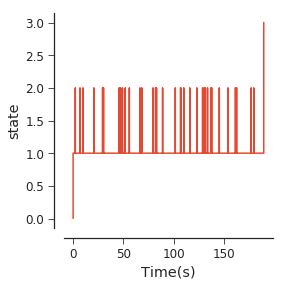

In [62]:
plot_state(df)

In [72]:
def photon_emission(df):
    fig = plt.figure(figsize=(8,4)) 
    plt.style.use('ggplot')
    sns.set_style('ticks')
    plt.rcParams['font.size'] = 12

    dff = pd.concat([df[['time','n_photon']],BE], axis=0, sort=False)
    dff['t'] = dff[['time','time_b']].fillna(0).sum(axis=1)
    dff['n_photon'] = dff['n_photon'].fillna(0)
    dff = dff.sort_values(by='t')
    dff.index = range(len(df['time'])+len(BE))
    dff['photon_b'] = np.where(dff['time_b']==dff['t'],1,0)
    dff['photon_tot'] =  dff['n_photon']+dff['photon_b']

    ax = fig.add_subplot(1,2,1)
    plt.plot(dff['t'],dff['photon_b'],'bo',label='Background Emission')
    plt.plot(dff['t'],dff['n_photon'],'ro',label='Photon Emission')
    plt.legend(['Background Emission','Photon Emission'])
    plt.ylabel('state')
    plt.xlabel('Time(s)')
    plt.tight_layout()
    sns.despine(offset=10)

    ax = fig.add_subplot(1,2,2)
    plt.plot(dff['t'],dff['photon_tot'],'bo',label='Total Emission')
    plt.ylabel('state')
    plt.xlabel('Time(s)')
    plt.tight_layout()
    sns.despine(offset=10)
    return None

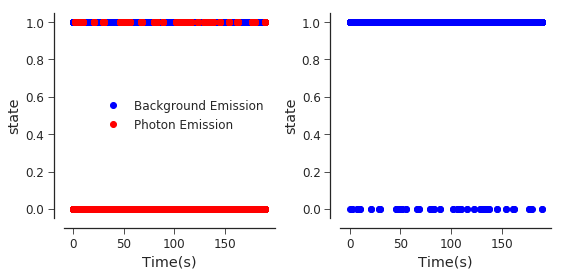

In [73]:
photon_emission(df)

### Inter-arrivel Time

In [85]:
def Interarrivel_time(df):
    fig = plt.figure(figsize=(4,4)) 
    plt.style.use('ggplot')
    sns.set_style('ticks')
    plt.rcParams['font.size'] = 12   
    switches = []
    for i in range(len(df)-1):
        if df['n_photon'][i+1]!=df['n_photon'][i]:
            switches.append(df['time'][i+1])
    dt = [switches[i+1]-switches[i] for i in range(len(switches)-1)]
    n, bins, patches = plt.hist(dt, 10, facecolor='blue')
    plt.ylabel('#Count(Photon)')
    plt.xlabel('Interarrivel Time(s)')
    plt.tight_layout()
    sns.despine(offset=10)
    return

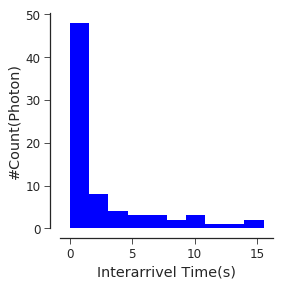

In [86]:
Interarrivel_time(df)